In [1]:
import stftAnSyn as stft
import dftAnSyn as dft

In [32]:
import numpy as np
from scipy.signal import get_window, blackmanharris
from scipy.signal import chirp, triang
from scipy.fftpack import ifft
import scipy.io.wavfile as wavfile
import os, sys
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal):
    signal = np.double(signal)
    return (signal - signal.mean()) / ((np.abs(signal)).max() + 0.0000000001)

In [4]:
sr = 44100
f0 = 150 # Hz
f1 = 8500 # Hz
t1 = 2 # seconds
t = np.linspace(0,t1,int(t1*sr))
chirpSig = chirp(t, f0, t1, f1)
wavfile.write("chirp.wav", sr, np.int16(chirpSig*2**14))

Text(0, 0.5, 'sample value')

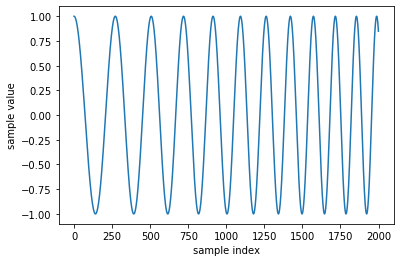

In [5]:
plt.plot(chirpSig[0:2000])
plt.xlabel('sample index')
plt.ylabel('sample value')

In [6]:
(fs, x) = wavfile.read('mono_noisy_hello.wav')

Text(0, 0.5, 'sample value')

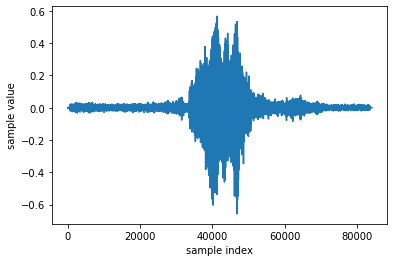

In [7]:
plt.plot(x[0:88000])
plt.xlabel('sample index')
plt.ylabel('sample value')

In [8]:
N = 512
M = 256
H = 128
w = get_window("blackman",M)
mX, phX = stft.stftAnal(x, w, N, H)
y = stft.stftSynth(mX, phX, w.size,H)
wavfile.write("newHello.wav", fs, y)

In [9]:
def peakDetection(mX, tresh):
    treshold = np.where(np.greater(mX[1:-1],tresh), mX[1:-1],0)
    next_minor = np.where(mX[1:-1] > mX[2:], mX[1:-1],0)
    previous_minor = np.where(mX[1:-1] > mX[:-2], mX[1:-1], 0)
    peak_locations = tresh * next_minor * previous_minor
    peak_locations = peak_locations.nonzero()[0] + 1
    return peak_locations

In [10]:
(fs, x) = wavfile.read('sine440.wav')

In [11]:
M = 512
N = 2048
tresh = -20
win = get_window('hamming',M)
x1 = x[int(.8*fs):int(.8*fs)+M]

In [12]:
(mX, pX) = dft.dftAnal(x1, win, N)
peaks = peakDetection(mX, tresh)
pMag = mX[peaks]

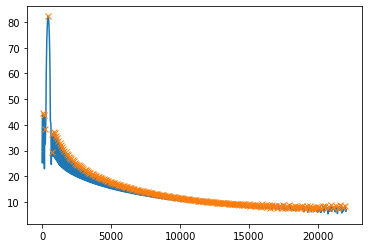

In [13]:
freqaxe = fs * np.arange(N/2+1)/float(N)
plt.plot(freqaxe, mX)
plt.plot(fs * peaks/ float(N), pMag, marker='x', linestyle='')
plt.show()

In [14]:
def peak_parabolicInterp(mX, pX, peaks):
    mags = mX[peaks]
    lmag = mX[peaks-1]
    rmag = mX[peaks+1]
    c_peak = peaks + 0.5 *(lmag-rmag)/(lmag-2*mags+rmag)
    pMag = mags - 0.25 * (lmag-rmag) * (c_peak - peaks)
    pPhase = np.interp(c_peak, np.arange(0, pX.size), pX)
    return c_peak, pMag, pPhase

In [15]:
pLoc, pMag, pPh = peak_parabolicInterp(mX, pX, peaks)

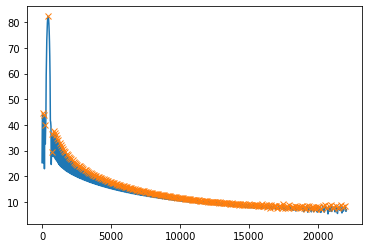

In [16]:
freqaxe = fs * np.arange(N/2+1)/float(N)
plt.plot(freqaxe, mX)
plt.plot(fs * pLoc/ float(N), pMag, marker='x', linestyle='')
plt.show()

In [17]:
# main lobe of a sinc function 
def sinc(x, N):
    y = np.sin(N * x/2) / np.sin(x/2)                  
    y[np.isnan(y)] = N                                 
    return y

# blackman-harris window main lobe
def genBhLobe(x):
    N = 512                                                 
    f = x*np.pi*2/N                                         
    df = 2*np.pi/N
    y = np.zeros(x.size)                                    
    consts = [0.35875, 0.48829, 0.14128, 0.01168]           # window constants
    for m in range(0,4):                                    
        y += consts[m]/2 * (sinc(f-df*m, N) + sinc(f+df*m, N))  
    y = y/N/consts[0]                                       
    return y

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


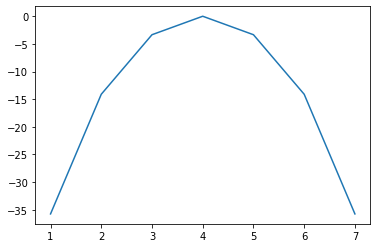

In [18]:
bins = np.array([-4,-3,-2,-1,0,1,2,3])
X = genBhLobe(bins)
plt.plot(20 * np.log10(X))

In [22]:
sf = 44100
N = 512
peakFreq = np.array([4000])
peakMag = np.array([0])
peakPhase = np.array([0])

In [23]:
def genSinesSpectrum(freq, mag, phase, N, fs):
    Y = np.zeros(N, dtype = complex)                 
    hN = N//2                                       
    for i in range(0, freq.size):                  # generate all sine spectral lobes
        loc = N * freq[i] / fs                     # it should be in range ]0,hN-1[
        if loc==0 or loc>hN-1: continue
        binremainder = round(loc)-loc;
        lb = np.arange(binremainder-4, binremainder+5) # main lobe (real value) bins to read
        lmag = genBhLobe(lb) * 10**(mag[i]/20)        
        b = np.arange(round(loc)-4, round(loc)+5, dtype='int')
        for m in range(0, 9):
            if b[m] < 0:                                 
                Y[-b[m]] += lmag[m]*np.exp(-1j*phase[i])
            elif b[m] > hN:                             
                Y[b[m]] += lmag[m]*np.exp(-1j*phase[i])
            elif b[m] == 0 or b[m] == hN:                
                Y[b[m]] += lmag[m]*np.exp(1j*phase[i]) + lmag[m]*np.exp(-1j*phase[i])
            else:                                        
                Y[b[m]] += lmag[m]*np.exp(1j*phase[i])
        Y[hN+1:] = Y[hN-1:0:-1].conjugate()            
    return Y

In [24]:
Y = genSinesSpectrum(peakFreq, peakMag, peakPhase, N, sf)

In [30]:
absY = abs(Y[:int(N/2)])
absY[absY < np.finfo(float).eps] = np.finfo(float).eps

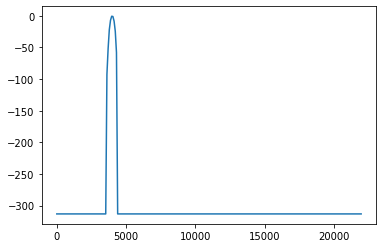

In [31]:
freqAxe = fs * np.arange(N/2)/float(N)
plt.plot(freqAxe, 20 * np.log10(absY))
plt.show()

In [35]:
hN = int(N/2)
y = np.real(ifft(Y))
synthwin = np.zeros(N)
ow = triang(N/2)
synthwin[hN-H:hN+H] = ow
bh = blackmanharris(N)
bh = bh/sum(bh)
synthwin[hN-H:hN+H] = synthwin[hN-H:hN+H] / bh[hN-H:hN+H] 

In [36]:
yw = np.zeros(N)
yw[:hN-1] = y[hN+1:]
yw[hN-1:] = y[:hN+1]
yw *= synthwin

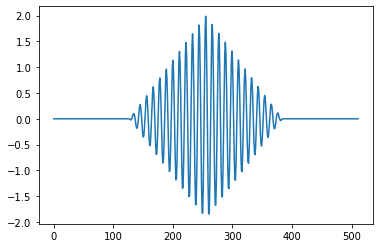

In [37]:
plt.plot(yw)
plt.show()

In [39]:
(fs, x) = wavfile.read('oboe-A4.wav')
N = 512
hN = int(N/2)
H = int(N/4)
M = 511
tresh = -70
win = get_window('hamming',M)
x1 = x[int(0.8*fs):int(0.8*fs)+M]
(mX, pX) = dft.dftAnal(x1,win,N)
peaks = peakDetection(mX, tresh)
(peakC, peakMag, peakPh) = peak_parabolicInterp(mX,pX,peaks)
peakFreq = fs*peaks/float(N)
Y = genSinesSpectrum(peakFreq, peakMag, peakPh, N, fs)
y = np.real(ifft(Y))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
synthesisWindow = np.zeros(N)
ow = triang(N/2)
synthesisWindow[hN-H:hN+H] = ow
bh = blackmanharris(N)
bh = bh / sum(bh)
synthesisWindow[hN-H:hN+H] = synthesisWindow[hN-H:hN+H] / bh[hN-H:hN+H]


In [54]:
ywin = np.zeros(N)
ywin[:hN-1] = y[hN+1:]
ywin[hN-1:] = y[:hN+1]
ywin *= synthesisWindow

<function matplotlib.pyplot.show(*args, **kw)>

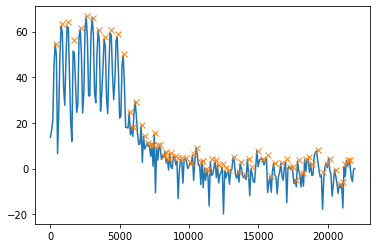

In [55]:
freqAxe = fs * np.arange(N/2)/float(N)
plt.plot(freqAxe, mX[1:])
plt.plot(fs*peaks / N, peakMag, marker='x',linestyle='')
plt.show

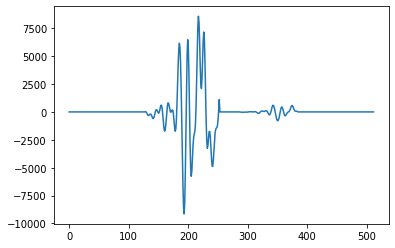

In [59]:
plt.plot(ywin)

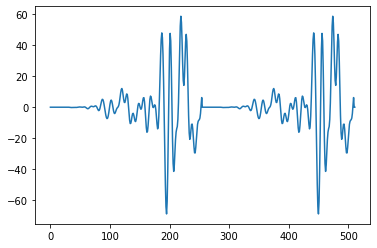

In [58]:
plt.plot(y)